In [106]:
!python --version

Python 3.10.0


## Imports

In [176]:
import os 
import re
import string
import numpy as np
import spacy as sp
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


os.environ['PYTHONHASHSEED'] = str(42) 
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISM'] = '1'

## Carregando os dados

In [237]:
dataset_path = 'dataset/'
dataset_name = 'dataset.csv'

dataset = pd.read_csv(os.path.join(dataset_path, dataset_name))
dataset

,sentence,category
0,"Auxílio-Doença Previdenciário, Benefícios em E...",orgão público
1,"PAGAR TODAS AS CONTAS EM ATRASO R$1.290,90.",finanças
2,Então encontraremos na próxima aula.,educação
3,Veja os resultados da categoria de ofertas do ...,indústrias
4,"Além disso, a embalagem é reutilizável e 100% ...","indústrias,varejo"
...,...,...
516,"Selecione o local de estudo, curso sem encontr...",educação
517,ESTUDANTES DA REDE MUNICIPAL VOLTAM ÀS AULAS E...,"educação,orgão público"
518,Empresas e órgãos públicos,orgão público
519,DGE – Departamento de Gestão Estratégica Metas...,orgão público


## Exploratória

In [238]:
texto = 'sentence'
setor = 'category'

dataset[texto].sample(5).tolist()

['Cumprimento de Sentença contra Fazenda Pública  Nº 5000524-55.2019(Processo Eletrônico - E-Proc V2 RS)',
 'Formas de pagamento: cartões de crédito ou transferência em conta',
 'Câmbio do novo carro Tracker 2022.',
 'Escolas Municipais de Educação Infantil (EMEIs), que atendem crianças de 4 a 5 anos e 11 meses.',
 'O dinheiro que sobra cada mês pode te ajudar a fazer aquela viagem nas férias.']

In [239]:
dataset[setor].value_counts()

category
orgão público               140
educação                    107
indústrias                   89
varejo                       85
finanças                     54
finanças,varejo              13
educação,orgão público        9
indústrias,varejo             7
educação,indústrias           5
finanças,orgão público        4
finanças,indústrias           3
indústrias,orgão público      2
educação,finanças             2
varejo,indústrias             1
Name: count, dtype: int64

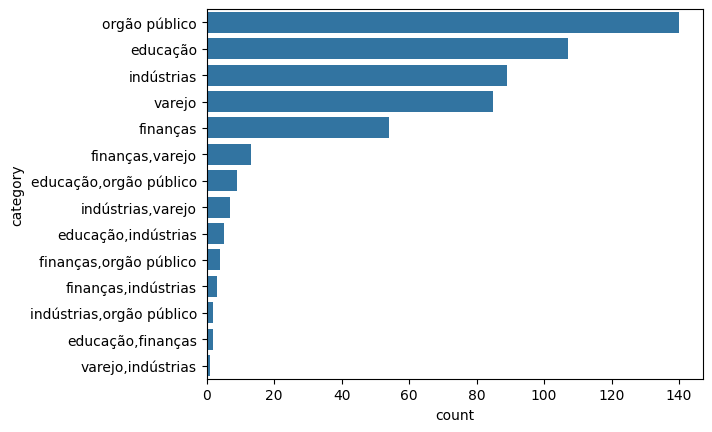

In [240]:
ordenados = dataset[setor].value_counts().index
sns.countplot(dataset[setor], order=ordenados);

Nesse momento, é importante decidir qual será a abordagem da modelagem. Com o desbalanceamento dos dados, dá a entender que considerar as classes múltiplas pode ser um problema e uma alternativa seria associar cada texto à um único setor, onde esses seriam 'copiados' e associados às demais classes. No entanto, isso poderia causar confusão no aprendizado do modelo.  

Dito isso, consideraremos a abordagem Multilabel. Aqui estão algumas justificativas:

- **Natureza do problema:**

    Mesmo que a maioria dos textos esteja associada a apenas uma categoria, a presença de casos de múltiplos rótulos justifica a adoção dessa estratégia.

- **Capacidade de capturar associações entre categorias:**

    A função de ativação sigmoid combinada com a binarização das classes, permite ao modelo atribuir probabilidades para cada categoria (saída da sigmoid é entre 0 e 1). Assim, mesmo que um texto seja associado a mais de uma classe, o modelo pode aprender a atribuir pesos diferentes a cada uma delas, capturando as associações entre as classes.

- **Aumento da capacidade do modelo de entender a complexidade:**

    Permitindo que o texto seja associado a mais de uma classe, o modelo se torna mais capaz de capturar a complexidade dos dados. Usar uma abordagem multilabel permite ao modelo capturar essas nuances e atribuir pesos apropriados a cada categoria.

- **Como a função sigmoid vai dar predizer mais de uma classe?**

    Nesse contexto, a função sigmoid vai dar o peso para as 5 classes (valores entre 0 e 1), aquelas que apresentarem o valor acima de um threashold estabelecido, serão consideradas as labels para o texto fornecido.

In [241]:
## A label com dois setor está assumindo o tipo 'string' única, precisamos fazer com que seja uma lista com duas strings
dataset[setor] = [set.split(',') for set in dataset[setor]]
dataset

,sentence,category
0,"Auxílio-Doença Previdenciário, Benefícios em E...",[orgão público]
1,"PAGAR TODAS AS CONTAS EM ATRASO R$1.290,90.",[finanças]
2,Então encontraremos na próxima aula.,[educação]
3,Veja os resultados da categoria de ofertas do ...,[indústrias]
4,"Além disso, a embalagem é reutilizável e 100% ...","[indústrias, varejo]"
...,...,...
516,"Selecione o local de estudo, curso sem encontr...",[educação]
517,ESTUDANTES DA REDE MUNICIPAL VOLTAM ÀS AULAS E...,"[educação, orgão público]"
518,Empresas e órgãos públicos,[orgão público]
519,DGE – Departamento de Gestão Estratégica Metas...,[orgão público]


## Tratamento dos textos

Uma vez com o dataset de textos e labels, é necessário fazer o tratamento dos textos para tornar o aprendizado do modelo mais eficiente. Para isso, é comum fazer a remoção de caracteres especiais e pontuações, assim como a  realização da tokenização (processo que divide o texto em unidades menores [palavras ou subpalavras]). Além disso, tambem devemos converter o texto para letras minúsculas para garantir consistência na contagem de palavras.

- Remover a acentuação.
- Remover caracteres especiais.
- Remover as 'stop words' que são palavras normalmente encaradas como 'ruído' no texto. 

Isso é importante para reduzirmos a dimensão de features e facilitar a identificação de padrões mais relevantes.

In [242]:
## Definindo stop words 
nlp = sp.blank("pt")
stop_words = sp.lang.pt.STOP_WORDS
[sw for sw in stop_words][:10]

['tiveram',
 'quer',
 'dos',
 'era',
 'diz',
 'fazia',
 'dezassete',
 'vem',
 'por',
 'primeira']

In [243]:
## Caracteres especiais
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [244]:
## Usando re (Regular Expression)
exemplo = 'Ele gosta de caçar'
re.sub(r"[ç]", "c", exemplo)  #Removendo o 'ç'

'Ele gosta de cacar'

In [245]:
def cleaning(text):
    text = text.lower()

    text = re.sub(r"[!@#%&$*º“”—-]", "", text)
    text = re.sub(r"[àáâãäåã]", "a", text)
    text = re.sub(r"[èéêë]", "e", text)
    text = re.sub(r"[ìíîï]", "i", text)
    text = re.sub(r"[òóôõö]", "o", text)
    text = re.sub(r"[ùúûü]", "u", text)
    text = re.sub(r"[ýÿ]", "y", text)
    text = re.sub(r"[ç]", "c", text)
    # text = re.sub(r"[0-9]", "", text)

    text = text.lower()
    document = nlp(text)

    words = []
    for token in document:
        words.append(token.text)

    words = [word for word in words if word not in stop_words and word not in string.punctuation] 
    words = ' '.join([str(element) for element in words])

    return words

In [246]:
## Comparando texto original com o texto processado
for text in dataset[texto].sample(5).tolist():
    print(text)
    print(cleaning(text))
    print('\n')

Chocolate 60% cacau café Lacta Intense pacote 85g.
chocolate 60 cacau cafe lacta intense pacote 85 g.


As normas nacionais de direitos humanos consistem, principalmente, de tratados e costumes, bem como diretrizes e princípios, entre outros.
normas nacionais direitos humanos consistem principalmente tratados costumes diretrizes principios


Nova Chevrolet S10 High Country 2022 , preto ouro.
chevrolet s10 high country 2022 preto ouro


Parcelas de R$1.699 no Nissan Replay.
parcelas r1.699 nissan replay


Justiça gratuita: Deferida
justica gratuita deferida




In [247]:
dataset[texto] = [cleaning(text) for text in dataset[texto]]
dataset

,sentence,category
0,auxiliodoenca previdenciario beneficios especi...,[orgão público]
1,"pagar contas atraso r1.290,90",[finanças]
2,entao encontraremos proxima aula,[educação]
3,resultados categoria ofertas modelo nissan kicks,[indústrias]
4,alem embalagem reutilizavel 100 reciclavel,"[indústrias, varejo]"
...,...,...
516,selecione estudo curso encontros presenciais,[educação]
517,estudantes rede municipal voltam aulas valparaiso,"[educação, orgão público]"
518,empresas orgaos publicos,[orgão público]
519,dge – departamento gestao estrategica metas na...,[orgão público]


#### Tokenização

Antes da tokenização, vamos definir X como os textos e y sendo a representação númerica de cada setor (aplicando o label enconding)

In [248]:
X = dataset[texto]

In [249]:
print('X >>\n',X[:5])

X >>
 0    auxiliodoenca previdenciario beneficios especi...
1                        pagar contas atraso r1.290,90
2                     entao encontraremos proxima aula
3     resultados categoria ofertas modelo nissan kicks
4           alem embalagem reutilizavel 100 reciclavel
Name: sentence, dtype: object


In [250]:
## Construindo o tokenizer (tendo 10 mil como o tamanho do vocabulario alvo)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X.tolist())
vocab_size = len(tokenizer.word_index) + 1

In [251]:
## Tamanho do vocabulário
vocab_size

1879

In [252]:
data_inputs = tokenizer.texts_to_sequences(X.tolist())
data_inputs[:5]

[[287, 50, 88, 89, 30, 50],
 [188, 189, 612, 125, 288, 51],
 [289, 613, 90, 64],
 [190, 290, 31, 614, 9, 126],
 [127, 291, 292, 91, 293]]

#### Padding

Uma vez que muitos modelos exigem que o dado de entrada sejam de uma dimensão em específico, vamos aplicar o padding para que todos os inputs sejam do mesmo tamanho. 

In [253]:
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value = 0,
                                                            padding = 'post',
                                                            maxlen=30)

In [254]:
data_inputs[:2]

array([[287,  50,  88,  89,  30,  50,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [188, 189, 612, 125, 288,  51,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0]])

## Modelagem

Como um primeiro modelo, optei criar uma Rede Neural Convolucional (CNN) que receberá os textos no formato `data_inputs`. Essa CNN processará o texto ao longo de camadas de convolução e pooling e, por fim, retornará a probabilidade do texto de entrada estar associado a cada classe possível.

Primeiro é necessário separar os dados de treino e os dados de teste.

In [255]:
mlb = MultiLabelBinarizer()
data_labels = mlb.fit_transform(dataset['category'])

train_inputs, test_inputs, train_labels, test_labels = train_test_split(data_inputs,
                                                                        data_labels,
                                                                        test_size=0.1,
                                                                        stratify = data_labels)

In [256]:
print('Shape dos dados de treinamento:',f'Inputs: {train_inputs.shape} Labels: {train_labels.shape}')
print('Shape dos dados de teste:',f'Inputs: {test_inputs.shape} Labels: {test_labels.shape}')

Shape dos dados de treinamento: Inputs: (468, 30) Labels: (468, 5)
Shape dos dados de teste: Inputs: (53, 30) Labels: (53, 5)


Criando o modelo

Iniciando o Treinamento 

In [257]:
def DCNN(vocab_size,
         emb_dim=128,
         nb_filters=50,
         ffn_units=512,
         nb_classes=2,
         dropout_rate=0.1,
         training=False,
         name='dcnn'):

    # Definindo a entrada do modelo
    inputs = tf.keras.Input(shape=(None,), name='input_text')

    # Camada de embeddings
    x = tf.keras.layers.Embedding(vocab_size, emb_dim)(inputs)

    # Convoluções de Bigrama seguidas por pooling
    conv1 = tf.keras.layers.Conv1D(filters=nb_filters, kernel_size=2, padding='same', activation='relu')(x)
    conv1 = tf.keras.layers.GlobalMaxPool1D()(conv1)

    # Convoluções de Trigrama seguidas por pooling
    conv2 = tf.keras.layers.Conv1D(filters=nb_filters, kernel_size=3, padding='same', activation='relu')(x)
    conv2 = tf.keras.layers.GlobalMaxPool1D()(conv2)

    # Convoluções de Trigrama seguidas por pooling
    conv3 = tf.keras.layers.Conv1D(filters=nb_filters, kernel_size=3, padding='same', activation='relu')(x)
    conv3 = tf.keras.layers.GlobalMaxPool1D()(conv3)

    # Convoluções de Quatrigrama seguidas por pooling
    conv4 = tf.keras.layers.Conv1D(filters=nb_filters, kernel_size=4, padding='same', activation='relu')(x)
    conv4 = tf.keras.layers.GlobalMaxPool1D()(conv4)

    # Convoluções de Quatrigrama seguidas por pooling
    conv5 = tf.keras.layers.Conv1D(filters=nb_filters, kernel_size=4, padding='same', activation='relu')(x)
    conv5 = tf.keras.layers.GlobalMaxPool1D()(conv5)

    # Concatenando as saídas das convoluções
    merged = tf.keras.layers.concatenate([conv1, conv2, conv3, conv4, conv5], axis=-1)

    # Rede densa
    dense = tf.keras.layers.Dense(units=ffn_units, activation='relu')(merged) # Camada densa inicial
    dropout = tf.keras.layers.Dropout(rate=dropout_rate)(dense, training=training) # Camada de dropout
    
    # Camada de saída
    outputs = tf.keras.layers.Dense(units=nb_classes, activation='sigmoid', name='output')(dropout)

    # Criando o modelo
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

    return model

Escolhendo valores para os parâmetros do modelo

In [258]:
## Parametros
vocab_size = len(tokenizer.word_index) + 1
emb_dim = 128
nb_filters = 100
ffn_units = 512
batch_size = 32
nb_classes = 5
dropout_rate = 0.2
nb_epochs = 100

In [259]:
## Inicializando modelo
model = DCNN(vocab_size=vocab_size, emb_dim=emb_dim, nb_filters=nb_filters,
            ffn_units=ffn_units, nb_classes=nb_classes, dropout_rate=dropout_rate)

In [260]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

Treinamento considerando 10% dos dados para validação

In [ ]:
tf.random.set_seed(1)
history = model.fit(train_inputs, train_labels,
            batch_size = batch_size,
            epochs = nb_epochs,
            verbose = 1,
            validation_split = .1)

results = model.evaluate(test_inputs, test_labels, batch_size=batch_size)

In [ ]:
## o output do treinamento do modelo foi removido para não poluir o notebook

In [265]:
print('loss: ',results[0],'\nacurácia: ',results[1])

loss:  0.5122183561325073 
acurácia:  0.7169811129570007


In [262]:
# ## Salvando o modelo 
model.save('CNN_MultiLabel_NLP.h5')
del model
model = load_model("CNN_MultiLabel_NLP.h5")

#### Avaliação do modelo

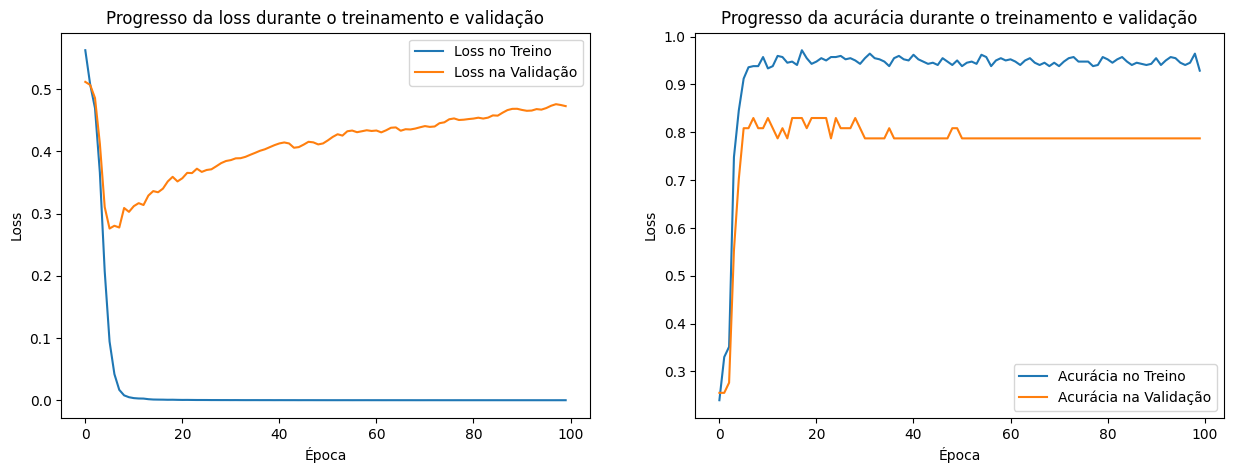

In [267]:
# Define o tamanho da figura
plt.figure(figsize=(15, 5))

# Primeiro subplot para loss
plt.subplot(1, 2, 1)  
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Progresso da loss durante o treinamento e validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend(['Loss no Treino', 'Loss na Validação'])

# Segundo subplot para accuracy
plt.subplot(1, 2, 2)  
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Progresso da acurácia durante o treinamento e validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend(['Acurácia no Treino', 'Acurácia na Validação']);

(Baseado na validação)
Com base nos plots, vemos que o modelo não foi tão eficiente no aprendizado, apresentando uma curva ascendente de Loss. No entanto, a acurácia foi razoavelmente bem acertando em média 78% das predições. 

In [285]:
from sklearn.metrics import multilabel_confusion_matrix

# Fazendo previsões no conjunto de teste
y_pred = model.predict(test_inputs)

# Convertendo as previsões para o formato de rótulos binarizados
threshold = 0.3
y_pred_binarized = (y_pred > threshold).astype(int)

# Calculando a matriz de confusão multilabel
confusion_matrix = multilabel_confusion_matrix(test_labels, y_pred_binarized)

# Exibindo a matriz de confusão para cada classe
for i, label in enumerate(mlb.classes_):
    print(f"Matriz de Confusão para a classe {label}:")
    print(confusion_matrix[i])
    print()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Matriz de Confusão para a classe educação:
[[40  0]
 [ 6  7]]

Matriz de Confusão para a classe finanças:
[[45  1]
 [ 5  2]]

Matriz de Confusão para a classe indústrias:
[[40  2]
 [ 2  9]]

Matriz de Confusão para a classe orgão público:
[[35  3]
 [ 6  9]]

Matriz de Confusão para a classe varejo:
[[40  2]
 [ 5  6]]



## Predizendo input

In [272]:
def predict_sector(text: object = 'Texto com o tema de interesse', threashold: float = 0.3) -> list:
    
    new_sentence = text

    # Pré-processamento da nova frase
    new_sentence_tokens = tokenizer.texts_to_sequences([new_sentence])
    new_sentence_tokens_padded = pad_sequences(new_sentence_tokens, padding='post', maxlen=100)

    # Previsão da nova frase
    predictions = model.predict(new_sentence_tokens_padded)

    # Decodificação da previsão
    threshold = 0.1  # Limiar de probabilidade para considerar a classe presente ou não
    predicted_labels = (predictions > threshold).astype(int)

    # Decodificando os rótulos previstos usando o MultiLabelBinarizer inverso
    predicted_categories = mlb.inverse_transform(predicted_labels)

    return [i for i in predicted_categories[0]]

Exemplos

In [275]:
predict_sector('No cartao com juros!')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


['finanças', 'varejo']

In [276]:
predict_sector('Faça curso de LIBRAS.')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


['educação']

In [284]:
predict_sector('As peças do carro enferrujaram.')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


['indústrias', 'varejo']